# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

C:\programs\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
int_words[1]

3080

In [7]:
from collections import Counter
import random
from math import sqrt

freqs = Counter(int_words)
corp_len=len(int_words)
t = random.uniform(0, 0.00003)
P_compare = random.uniform(0.5, 1)

word_counts = {word:(1-sqrt(t/(freqs[word]/corp_len))) for word in int_words}
train_words = [word for word in int_words if word_counts[word]<P_compare]

In [8]:
len(train_words), corp_len

(15619203, 16680599)

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [9]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    r = random.randint(1,window_size+1)
    #print(r)
    start_ind = idx-r if r<idx else 0
    end_ind = idx+r
    
    return set(words[start_ind:idx] + words[idx+1:end_ind])

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [10]:
print(get_target([1,2,3,4,5], 3))

{1, 2, 3, 5}


In [11]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [12]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[None], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None,1], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [13]:
n_vocab = len(int_to_vocab)
n_embed =  200
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embed), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs, name='embed')

In [14]:
embedding

<tf.Variable 'Variable:0' shape=(63641, 200) dtype=float32_ref>

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [15]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal([n_vocab,n_embed],
                      stddev=1.0 / sqrt(n_embed)))
    softmax_b = tf.Variable(np.zeros((n_vocab), dtype='float32'))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(weights=softmax_w, biases=softmax_b, labels=labels, 
                                      inputs = embed, num_sampled=n_sampled, num_classes=n_vocab) 
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [16]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

Џ®¤Ї ЇЄ  Ё«Ё д ©« checkpoints г¦Ґ бгйҐбвўгҐв.


## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [18]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph, config=tf.ConfigProto(log_device_placement=True)) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            #print("I'm working")
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 7.7367 0.5942 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 7.1855 0.5852 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 6.5017 0.6096 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 6.0734 0.5837 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.7449 0.5803 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5008 0.5870 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.3627 0.5838 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.2466 0.5821 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.0867 0.5927 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 4.9398 0.5999 sec/batch
Nearest to were: state, ideas, violate, portugal, amusing, abandon, spingarn, thinly,
Nearest to first: panentheism, aristotle, have, third, slate, senile, receivers, probably,
Nearest to while: inclination, crime, floating, acid, tropospheric, knowledge, bronze, forms,
Nearest to may: sort, succee

Nearest to report: similarities, mick, montage, democracies, hindus, objection, twinning, nonferrous,
Nearest to derived: magnum, tweet, typified, renderer, reviewer, detected, summon, extensively,
Nearest to applications: showed, douglass, commute, irresponsibility, hindus, tversky, indicated, differentiate,
Nearest to ice: ogden, writings, upbeat, oxidizing, ctr, adin, ablative, falcon,
Nearest to rise: mariano, swing, archipelago, graves, utc, condemns, jurists, vu,
Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6296 0.5743 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.5947 0.5740 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.6177 0.5766 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.6117 0.5762 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 4.6138 0.5757 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 4.6541 0.5739 sec/batch
Epoch 1/10 Iteration: 4700 Avg. Training loss: 4.5835 0.5671 sec/batch
Epoch 1/10 Iteration: 4800 Av

Nearest to war: heisman, prussian, during, harlem, commemoration, volunteer, schiller, banjar,
Nearest to if: infeasible, callsign, lfr, exogenous, punches, redeemed, numerical, wilhelms,
Nearest to of: homeomorphic, entitlement, jure, ribbentrop, arab, bing, reserving, affixed,
Nearest to with: attenborough, mingle, square, registries, synergy, reforms, halo, shapeshifting,
Nearest to engine: horch, acidosis, leninism, pointing, nella, canvas, baffled, undergone,
Nearest to issue: unnoticed, attendants, digweed, isomerism, humanity, kz, pollack, zealous,
Nearest to versions: offensives, bade, originates, manu, caucasoid, buying, ihs, heating,
Nearest to report: similarities, montage, mick, mastelotto, objection, casing, nonferrous, curiosities,
Nearest to derived: renderer, tweet, word, carn, magnum, reviewer, bitmap, pleroma,
Nearest to applications: protists, differentiate, showed, commute, tutoring, douglass, hindus, compressed,
Nearest to ice: braid, ctr, ogden, ablative, norden, 

Epoch 1/10 Iteration: 11700 Avg. Training loss: 4.3572 0.5897 sec/batch
Epoch 1/10 Iteration: 11800 Avg. Training loss: 4.0267 0.5990 sec/batch
Epoch 1/10 Iteration: 11900 Avg. Training loss: 4.4011 0.6043 sec/batch
Epoch 1/10 Iteration: 12000 Avg. Training loss: 4.2651 0.6795 sec/batch
Nearest to were: are, spingarn, alas, chrome, deport, cyclones, eulogy, thinly,
Nearest to first: panentheism, third, senile, homophonic, aristotle, llobregat, eighteenth, sagrada,
Nearest to while: ungodly, khmer, tropospheric, inclination, rages, spouses, annoyed, kuan,
Nearest to may: fontaine, factoring, jacobean, porch, triumphed, adidas, painted, confidence,
Nearest to war: prussian, heisman, banjar, volunteer, during, interceptors, commemoration, amsterdam,
Nearest to if: infeasible, callsign, exogenous, lfr, punches, orwellian, timeframe, redeemed,
Nearest to of: jure, madison, normandy, ribbentrop, diena, rensselaer, dowling, perplexing,
Nearest to with: attenborough, mingle, kuznetsov, equaliz

Nearest to applications: showed, tutoring, irresponsibility, protists, trotting, balm, differentiate, unix,
Nearest to ice: norden, braid, ogden, ablative, badge, dehydration, rifts, upbeat,
Nearest to rise: mariano, swing, archipelago, jurists, mili, vu, trapper, enact,
Epoch 1/10 Iteration: 15100 Avg. Training loss: 4.3849 0.6553 sec/batch
Epoch 1/10 Iteration: 15200 Avg. Training loss: 4.3861 0.6620 sec/batch
Epoch 1/10 Iteration: 15300 Avg. Training loss: 4.4064 0.6302 sec/batch
Epoch 1/10 Iteration: 15400 Avg. Training loss: 4.4188 0.5475 sec/batch
Epoch 1/10 Iteration: 15500 Avg. Training loss: 4.4753 0.5659 sec/batch
Epoch 1/10 Iteration: 15600 Avg. Training loss: 4.5024 0.5387 sec/batch
Epoch 2/10 Iteration: 15700 Avg. Training loss: 4.4619 0.4368 sec/batch
Epoch 2/10 Iteration: 15800 Avg. Training loss: 4.4314 0.5331 sec/batch
Epoch 2/10 Iteration: 15900 Avg. Training loss: 4.3985 0.5316 sec/batch
Epoch 2/10 Iteration: 16000 Avg. Training loss: 4.4384 0.5346 sec/batch
Nearest 

Nearest to of: jure, polled, revolvers, bing, homeomorphic, albatrosses, assured, diena,
Nearest to with: attenborough, mingle, synergy, lddc, disrupt, equalizer, heian, distributions,
Nearest to engine: horch, valueless, yetzer, acidosis, akm, canvas, engines, orchard,
Nearest to issue: digweed, unnoticed, attendants, humanity, pollack, radical, aspects, plush,
Nearest to versions: caucasoid, ihs, dazzle, corrupted, bade, anesthetics, api, modes,
Nearest to report: similarities, website, osiander, casing, june, cinerama, mastelotto, objection,
Nearest to derived: word, tweet, grammar, entrapped, carn, literally, pleroma, renderer,
Nearest to applications: showed, tutoring, irresponsibility, antidepressants, unix, compacted, embedded, trotting,
Nearest to ice: braid, norden, ablative, ogden, dehydration, badge, rifts, falcon,
Nearest to rise: archipelago, swing, mariano, vu, mili, jurists, montoku, graves,
Epoch 2/10 Iteration: 19100 Avg. Training loss: 4.4074 0.5633 sec/batch
Epoch 2/

Epoch 2/10 Iteration: 22800 Avg. Training loss: 4.3963 0.6642 sec/batch
Epoch 2/10 Iteration: 22900 Avg. Training loss: 4.4001 0.6771 sec/batch
Epoch 2/10 Iteration: 23000 Avg. Training loss: 4.3644 0.6324 sec/batch
Nearest to were: are, was, spingarn, deport, tavola, discrepancies, koopa, petrie,
Nearest to first: third, senile, panentheism, llobregat, homophonic, plebeians, aristotle, eighteenth,
Nearest to while: ungodly, khmer, wonderful, kuan, daughters, outfit, tropospheric, anemometers,
Nearest to may: can, might, factoring, fontaine, jacobean, coherently, strychnine, electrophoretic,
Nearest to war: banjar, prussian, battle, volunteer, amsterdam, interceptors, objectives, during,
Nearest to if: infeasible, exogenous, callsign, redeemed, subset, gentleman, infinity, count,
Nearest to of: jure, assured, homeomorphic, ahman, diena, cyclo, albatrosses, representing,
Nearest to with: attenborough, lddc, kuznetsov, starfire, equalizer, mingle, closet, heian,
Nearest to engine: yetzer

Nearest to ice: norden, dehydration, braid, ablative, badge, upbeat, rifts, spins,
Nearest to rise: swing, movement, jurists, archipelago, mili, mariano, vu, montoku,
Epoch 2/10 Iteration: 26100 Avg. Training loss: 4.3731 0.6687 sec/batch
Epoch 2/10 Iteration: 26200 Avg. Training loss: 4.4071 0.6608 sec/batch
Epoch 2/10 Iteration: 26300 Avg. Training loss: 4.3968 0.6377 sec/batch
Epoch 2/10 Iteration: 26400 Avg. Training loss: 4.3795 0.6216 sec/batch
Epoch 2/10 Iteration: 26500 Avg. Training loss: 4.2678 0.6249 sec/batch
Epoch 2/10 Iteration: 26600 Avg. Training loss: 4.3752 0.6402 sec/batch
Epoch 2/10 Iteration: 26700 Avg. Training loss: 4.3564 0.6178 sec/batch
Epoch 2/10 Iteration: 26800 Avg. Training loss: 4.3231 0.6483 sec/batch
Epoch 2/10 Iteration: 26900 Avg. Training loss: 4.3641 0.6158 sec/batch
Epoch 2/10 Iteration: 27000 Avg. Training loss: 4.3683 0.6049 sec/batch
Nearest to were: are, was, spingarn, tavola, discrepancies, deport, koopa, quarterfinal,
Nearest to first: third,

Nearest to with: lddc, equalizer, attenborough, starfire, disrupt, ogden, boulevard, freeview,
Nearest to engine: engines, yetzer, valueless, horch, orchard, canvas, acidosis, akm,
Nearest to issue: digweed, unnoticed, pollack, radical, aspects, plush, attendants, kz,
Nearest to versions: ihs, api, caucasoid, corrupted, tolkowsky, modes, dazzle, gnu,
Nearest to report: similarities, osiander, website, june, inform, identifies, objection, kimura,
Nearest to derived: word, tweet, pleroma, entrapped, carn, grammar, literally, ape,
Nearest to applications: showed, embedded, tutoring, irresponsibility, antidepressants, trotting, compacted, douglass,
Nearest to ice: norden, braid, dehydration, ablative, rifts, upbeat, haihowak, badge,
Nearest to rise: swing, archipelago, jurists, montoku, mariano, vu, yage, mili,
Epoch 2/10 Iteration: 30100 Avg. Training loss: 4.3465 0.6190 sec/batch
Epoch 2/10 Iteration: 30200 Avg. Training loss: 4.3522 0.6363 sec/batch
Epoch 2/10 Iteration: 30300 Avg. Trai

Nearest to were: are, was, spingarn, tavola, deport, discrepancies, koopa, enactments,
Nearest to first: third, llobregat, homophonic, senile, panentheism, plebeians, airs, warehousing,
Nearest to while: ungodly, khmer, kuan, quetelet, outfit, wayne, although, tact,
Nearest to may: can, might, could, factoring, should, fontaine, would, will,
Nearest to war: banjar, prussian, battle, volunteer, ve, veterans, objectives, amsterdam,
Nearest to if: infeasible, exogenous, callsign, gentleman, count, mindless, redeemed, subset,
Nearest to of: representing, homeomorphic, hues, albatrosses, bing, comedies, koenigsegg, squared,
Nearest to with: lddc, attenborough, freeview, closet, starfire, kuznetsov, equalizer, disrupt,
Nearest to engine: horch, engines, valueless, yetzer, orchard, canvas, coprocessor, silmarillion,
Nearest to issue: digweed, pollack, unnoticed, plush, radical, aspects, kz, attendants,
Nearest to versions: ihs, api, arundel, corrupted, packaged, thirties, tolkowsky, caucasoid

Epoch 3/10 Iteration: 37300 Avg. Training loss: 4.3005 0.6174 sec/batch
Epoch 3/10 Iteration: 37400 Avg. Training loss: 4.3766 0.6815 sec/batch
Epoch 3/10 Iteration: 37500 Avg. Training loss: 4.3448 0.6737 sec/batch
Epoch 3/10 Iteration: 37600 Avg. Training loss: 4.3617 0.6758 sec/batch
Epoch 3/10 Iteration: 37700 Avg. Training loss: 4.3543 0.6766 sec/batch
Epoch 3/10 Iteration: 37800 Avg. Training loss: 4.3777 0.6650 sec/batch
Epoch 3/10 Iteration: 37900 Avg. Training loss: 4.3331 0.6026 sec/batch
Epoch 3/10 Iteration: 38000 Avg. Training loss: 4.2789 0.5873 sec/batch
Nearest to were: are, was, tavola, spingarn, discrepancies, deport, koopa, enactments,
Nearest to first: third, llobregat, senile, homophonic, panentheism, plebeians, airs, pacing,
Nearest to while: ungodly, khmer, quetelet, although, outfit, scorched, reporter, wayne,
Nearest to may: can, might, could, should, would, factoring, strychnine, grounds,
Nearest to war: banjar, prussian, battle, ve, veterans, volunteer, objec

Nearest to report: similarities, inform, osiander, identifies, website, visage, fortean, whaling,
Nearest to derived: word, tweet, entrapped, compound, literally, pleroma, ape, from,
Nearest to applications: showed, embedded, irresponsibility, nabawi, tutoring, antidepressants, douglass, utilize,
Nearest to ice: norden, dehydration, braid, upbeat, rifts, ablative, spins, hockey,
Nearest to rise: swing, jurists, montoku, vu, mili, yage, spanking, enact,
Epoch 3/10 Iteration: 41100 Avg. Training loss: 4.3583 0.5996 sec/batch
Epoch 3/10 Iteration: 41200 Avg. Training loss: 4.3844 0.6058 sec/batch
Epoch 3/10 Iteration: 41300 Avg. Training loss: 4.3368 0.6352 sec/batch
Epoch 3/10 Iteration: 41400 Avg. Training loss: 4.3162 0.6005 sec/batch
Epoch 3/10 Iteration: 41500 Avg. Training loss: 4.3652 0.6312 sec/batch
Epoch 3/10 Iteration: 41600 Avg. Training loss: 4.3598 0.6406 sec/batch
Epoch 3/10 Iteration: 41700 Avg. Training loss: 4.3469 0.6858 sec/batch
Epoch 3/10 Iteration: 41800 Avg. Traini

Nearest to if: exogenous, infeasible, callsign, subset, participles, inhalants, since, myeloid,
Nearest to of: representing, chimaera, loyola, diena, reserving, polled, rhode, homeomorphic,
Nearest to with: lddc, attenborough, starfire, freeview, ogden, kuznetsov, equalizer, closet,
Nearest to engine: engines, valueless, horch, yetzer, orchard, sip, canvas, coprocessor,
Nearest to issue: digweed, pollack, unnoticed, radical, lemass, plush, aspects, micronational,
Nearest to versions: ihs, api, corrupted, incremental, stwertka, version, thirties, tolkowsky,
Nearest to report: similarities, osiander, inform, identifies, fortean, website, visage, kimura,
Nearest to derived: word, compound, tweet, literally, pleroma, from, meaning, entrapped,
Nearest to applications: showed, irresponsibility, utilize, tutoring, embedded, antidepressants, home, nabawi,
Nearest to ice: norden, braid, upbeat, dehydration, hockey, rifts, haihowak, whitacre,
Nearest to rise: swing, jurists, montoku, vu, enact, 

Epoch 4/10 Iteration: 49000 Avg. Training loss: 4.3305 0.5730 sec/batch
Nearest to were: are, was, tavola, spingarn, koopa, stormbl, deport, discrepancies,
Nearest to first: third, llobregat, second, panentheism, senile, homophonic, webcomics, pacing,
Nearest to while: ungodly, although, khmer, quetelet, wayne, scorched, tact, daughters,
Nearest to may: can, might, could, would, will, should, must, strychnine,
Nearest to war: banjar, ve, veterans, prussian, barrack, battle, volunteer, vengeful,
Nearest to if: infeasible, exogenous, callsign, inhalants, redeemed, participles, gentleman, myeloid,
Nearest to of: representing, hues, verdun, albatrosses, diena, jure, loyola, homeomorphic,
Nearest to with: lddc, freeview, closet, starfire, attenborough, ogden, equalizer, disrupt,
Nearest to engine: engines, valueless, horch, yetzer, orchard, petrol, sip, silmarillion,
Nearest to issue: digweed, pollack, unnoticed, radical, disney, micronational, lemass, khmer,
Nearest to versions: ihs, api, 

Epoch 4/10 Iteration: 52400 Avg. Training loss: 4.3554 0.5734 sec/batch
Epoch 4/10 Iteration: 52500 Avg. Training loss: 4.3662 0.5936 sec/batch
Epoch 4/10 Iteration: 52600 Avg. Training loss: 4.2723 0.5715 sec/batch
Epoch 4/10 Iteration: 52700 Avg. Training loss: 4.2945 0.5653 sec/batch
Epoch 4/10 Iteration: 52800 Avg. Training loss: 4.3207 0.5662 sec/batch
Epoch 4/10 Iteration: 52900 Avg. Training loss: 4.2762 0.5694 sec/batch
Epoch 4/10 Iteration: 53000 Avg. Training loss: 4.3144 0.6035 sec/batch
Nearest to were: are, was, koopa, spingarn, tavola, discrepancies, stormbl, deport,
Nearest to first: third, second, llobregat, airs, fourth, pacing, homophonic, senile,
Nearest to while: although, ungodly, wayne, khmer, scorched, when, quetelet, outfit,
Nearest to may: can, might, could, would, will, should, must, strychnine,
Nearest to war: banjar, ve, veterans, ww, barrack, franchisee, objectives, ii,
Nearest to if: infeasible, exogenous, subset, since, callsign, participles, count, inhal

Nearest to applications: showed, embedded, nabawi, utilize, douglass, home, verizon, tutoring,
Nearest to ice: norden, rifts, upbeat, hockey, dehydration, spins, braid, uprising,
Nearest to rise: swing, jurists, montoku, vu, spanking, enact, yage, unemployment,
Epoch 4/10 Iteration: 56100 Avg. Training loss: 4.3190 0.5863 sec/batch
Epoch 4/10 Iteration: 56200 Avg. Training loss: 4.3426 0.5954 sec/batch
Epoch 4/10 Iteration: 56300 Avg. Training loss: 4.3492 0.5792 sec/batch
Epoch 4/10 Iteration: 56400 Avg. Training loss: 4.3653 0.5671 sec/batch
Epoch 4/10 Iteration: 56500 Avg. Training loss: 4.3160 0.5690 sec/batch
Epoch 4/10 Iteration: 56600 Avg. Training loss: 4.2503 0.5670 sec/batch
Epoch 4/10 Iteration: 56700 Avg. Training loss: 4.3253 0.5722 sec/batch
Epoch 4/10 Iteration: 56800 Avg. Training loss: 4.3557 0.5672 sec/batch
Epoch 4/10 Iteration: 56900 Avg. Training loss: 4.3220 0.5645 sec/batch
Epoch 4/10 Iteration: 57000 Avg. Training loss: 4.2998 0.5771 sec/batch
Nearest to were: a

Nearest to engine: engines, valueless, horch, yetzer, orchard, sip, petrol, tithe,
Nearest to issue: digweed, pollack, radical, lemass, khmer, micronational, debate, disney,
Nearest to versions: ihs, version, corrupted, stwertka, hunmin, prodigies, dreamt, arundel,
Nearest to report: similarities, inform, estimates, osiander, identifies, fortean, nacl, mobygames,
Nearest to derived: word, comes, meaning, tweet, compound, literally, entrapped, from,
Nearest to applications: showed, nabawi, home, irresponsibility, embedded, utilize, douglass, tutoring,
Nearest to ice: norden, rifts, upbeat, hockey, uprising, socket, ogden, whitacre,
Nearest to rise: swing, jurists, montoku, enact, vu, spanking, birth, mili,
Epoch 4/10 Iteration: 60100 Avg. Training loss: 4.1754 0.5719 sec/batch
Epoch 4/10 Iteration: 60200 Avg. Training loss: 4.3321 0.5682 sec/batch
Epoch 4/10 Iteration: 60300 Avg. Training loss: 4.3498 0.5710 sec/batch
Epoch 4/10 Iteration: 60400 Avg. Training loss: 4.2820 0.5671 sec/bat

Nearest to war: banjar, veterans, ve, ww, barrack, franchisee, battle, freethinkers,
Nearest to if: participles, infeasible, exogenous, since, then, myeloid, stare, redeemed,
Nearest to of: representing, dicotyledons, hemiparesis, tei, loyola, jutsu, diena, verdun,
Nearest to with: attenborough, lddc, starfire, freeview, ogden, closet, ncia, slenska,
Nearest to engine: engines, valueless, horch, orchard, yetzer, petrol, sip, silmarillion,
Nearest to issue: digweed, pollack, khmer, radical, micronational, debate, lemass, unnoticed,
Nearest to versions: ihs, version, corrupted, hunmin, stwertka, prodigies, raged, incremental,
Nearest to report: similarities, estimates, identifies, inform, mobygames, nacl, polaroid, osiander,
Nearest to derived: comes, word, from, meaning, derives, literally, tweet, compound,
Nearest to applications: showed, utilize, irresponsibility, nabawi, home, douglass, verizon, travelled,
Nearest to ice: norden, rifts, uprising, hockey, haihowak, whitacre, aborigina

Nearest to were: are, was, tavola, spingarn, stormbl, koopa, had, deport,
Nearest to first: third, second, fourth, llobregat, later, airs, kraft, pacing,
Nearest to while: although, when, ungodly, khmer, wayne, though, aimed, scorched,
Nearest to may: can, might, could, would, will, must, should, strychnine,
Nearest to war: banjar, ve, veterans, ww, franchisee, ii, barrack, niacin,
Nearest to if: then, since, infeasible, participles, exogenous, subset, when, count,
Nearest to of: representing, dicotyledons, enzyte, herbrand, rabban, boomerangs, hues, galbraith,
Nearest to with: freeview, attenborough, closet, lddc, ogden, disrupt, slenska, nystagmus,
Nearest to engine: engines, valueless, horch, orchard, yetzer, sip, petrol, atmospheres,
Nearest to issue: digweed, pollack, radical, khmer, debate, micronational, lemass, unnoticed,
Nearest to versions: ihs, version, corrupted, hunmin, heating, stwertka, dreamt, raged,
Nearest to report: similarities, estimates, inform, identifies, nacl, 

Epoch 5/10 Iteration: 71700 Avg. Training loss: 4.3161 0.5485 sec/batch
Epoch 5/10 Iteration: 71800 Avg. Training loss: 4.3232 0.5520 sec/batch
Epoch 5/10 Iteration: 71900 Avg. Training loss: 4.3319 0.5497 sec/batch
Epoch 5/10 Iteration: 72000 Avg. Training loss: 4.3562 0.5512 sec/batch
Nearest to were: are, was, spingarn, koopa, stormbl, tavola, had, deport,
Nearest to first: third, second, fourth, llobregat, later, airs, chipping, kraft,
Nearest to while: although, when, ungodly, though, quetelet, and, however, wayne,
Nearest to may: can, could, might, would, will, must, should, strychnine,
Nearest to war: banjar, ve, veterans, ww, franchisee, ii, barrack, battle,
Nearest to if: then, thus, when, participles, since, exogenous, stare, infeasible,
Nearest to of: koenigsegg, hues, homeomorphic, hemiparesis, timeless, dicotyledons, prosecutorial, loyola,
Nearest to with: attenborough, ogden, carlin, starfire, closet, lddc, freeview, strained,
Nearest to engine: engines, valueless, horch,

Epoch 5/10 Iteration: 75300 Avg. Training loss: 4.3718 0.5528 sec/batch
Epoch 5/10 Iteration: 75400 Avg. Training loss: 4.3682 0.5478 sec/batch
Epoch 5/10 Iteration: 75500 Avg. Training loss: 4.3344 0.5533 sec/batch
Epoch 5/10 Iteration: 75600 Avg. Training loss: 4.3178 0.5471 sec/batch
Epoch 5/10 Iteration: 75700 Avg. Training loss: 4.1009 0.5464 sec/batch
Epoch 5/10 Iteration: 75800 Avg. Training loss: 4.3333 0.5498 sec/batch
Epoch 5/10 Iteration: 75900 Avg. Training loss: 4.3275 0.5507 sec/batch
Epoch 5/10 Iteration: 76000 Avg. Training loss: 4.2855 0.5489 sec/batch
Nearest to were: are, was, tavola, koopa, spingarn, stormbl, had, became,
Nearest to first: third, second, fourth, later, llobregat, airs, last, panentheism,
Nearest to while: although, when, however, though, khmer, and, ungodly, wayne,
Nearest to may: can, could, might, would, will, must, should, strychnine,
Nearest to war: banjar, veterans, ve, ww, franchisee, barrack, ii, harbor,
Nearest to if: then, thus, subset, whe

Nearest to rise: swing, enact, jurists, birth, vu, montoku, yage, radiate,
Epoch 6/10 Iteration: 79100 Avg. Training loss: 4.2123 0.5532 sec/batch
Epoch 6/10 Iteration: 79200 Avg. Training loss: 4.2319 0.5608 sec/batch
Epoch 6/10 Iteration: 79300 Avg. Training loss: 4.3188 0.5513 sec/batch
Epoch 6/10 Iteration: 79400 Avg. Training loss: 4.2949 0.5490 sec/batch
Epoch 6/10 Iteration: 79500 Avg. Training loss: 4.2691 0.5473 sec/batch
Epoch 6/10 Iteration: 79600 Avg. Training loss: 4.2774 0.5486 sec/batch
Epoch 6/10 Iteration: 79700 Avg. Training loss: 4.2851 0.5485 sec/batch
Epoch 6/10 Iteration: 79800 Avg. Training loss: 4.3307 0.5497 sec/batch
Epoch 6/10 Iteration: 79900 Avg. Training loss: 4.2713 0.5493 sec/batch
Epoch 6/10 Iteration: 80000 Avg. Training loss: 4.3263 0.5478 sec/batch
Nearest to were: are, was, had, became, tavola, koopa, stormbl, began,
Nearest to first: third, second, fourth, later, llobregat, last, earliest, pacing,
Nearest to while: although, when, however, though, 

Nearest to applications: nabawi, utilize, travelled, irresponsibility, showed, detectors, douglass, karoo,
Nearest to ice: hockey, norden, uprising, rifts, socket, stone, upbeat, aboriginal,
Nearest to rise: swing, enact, birth, vu, jurists, montoku, radiate, orthogonal,
Epoch 6/10 Iteration: 83100 Avg. Training loss: 4.3171 0.5835 sec/batch
Epoch 6/10 Iteration: 83200 Avg. Training loss: 4.3090 0.5665 sec/batch
Epoch 6/10 Iteration: 83300 Avg. Training loss: 4.3090 0.5556 sec/batch
Epoch 6/10 Iteration: 83400 Avg. Training loss: 4.3046 0.6294 sec/batch
Epoch 6/10 Iteration: 83500 Avg. Training loss: 4.2824 0.6323 sec/batch
Epoch 6/10 Iteration: 83600 Avg. Training loss: 4.3304 0.6361 sec/batch
Epoch 6/10 Iteration: 83700 Avg. Training loss: 4.3342 0.6001 sec/batch
Epoch 6/10 Iteration: 83800 Avg. Training loss: 4.2432 0.5629 sec/batch
Epoch 6/10 Iteration: 83900 Avg. Training loss: 4.2827 0.5674 sec/batch
Epoch 6/10 Iteration: 84000 Avg. Training loss: 4.2897 0.5657 sec/batch
Nearest 

Nearest to derived: comes, derives, meaning, word, away, descended, from, literally,
Nearest to applications: travelled, nabawi, showed, detectors, utilize, antidepressants, karoo, mainframes,
Nearest to ice: norden, uprising, hockey, socket, rifts, aboriginal, stone, coms,
Nearest to rise: enact, swing, birth, jurists, vu, montoku, radiate, yage,
Epoch 6/10 Iteration: 87100 Avg. Training loss: 4.3299 0.5993 sec/batch
Epoch 6/10 Iteration: 87200 Avg. Training loss: 4.3010 0.5983 sec/batch
Epoch 6/10 Iteration: 87300 Avg. Training loss: 4.3133 0.6028 sec/batch
Epoch 6/10 Iteration: 87400 Avg. Training loss: 4.3034 0.5735 sec/batch
Epoch 6/10 Iteration: 87500 Avg. Training loss: 4.3140 0.6283 sec/batch
Epoch 6/10 Iteration: 87600 Avg. Training loss: 4.3478 0.6187 sec/batch
Epoch 6/10 Iteration: 87700 Avg. Training loss: 4.3121 0.6181 sec/batch
Epoch 6/10 Iteration: 87800 Avg. Training loss: 4.2355 0.6358 sec/batch
Epoch 6/10 Iteration: 87900 Avg. Training loss: 4.2729 0.6082 sec/batch
Ep

Nearest to versions: version, ihs, hunmin, features, types, translations, formats, stages,
Nearest to report: estimates, nacl, similarities, sama, identifies, inform, observer, crowding,
Nearest to derived: comes, derives, meaning, away, word, descended, literally, apart,
Nearest to applications: nabawi, travelled, environments, antidepressants, douglass, irresponsibility, subjects, vcore,
Nearest to ice: norden, uprising, hockey, rifts, combats, stone, aboriginal, socket,
Nearest to rise: enact, swing, birth, jurists, vu, montoku, graveyards, melting,
Epoch 6/10 Iteration: 91100 Avg. Training loss: 4.3356 0.5606 sec/batch
Epoch 6/10 Iteration: 91200 Avg. Training loss: 4.3086 0.5524 sec/batch
Epoch 6/10 Iteration: 91300 Avg. Training loss: 4.1194 0.5517 sec/batch
Epoch 6/10 Iteration: 91400 Avg. Training loss: 4.3222 0.5516 sec/batch
Epoch 6/10 Iteration: 91500 Avg. Training loss: 4.3029 0.5550 sec/batch
Epoch 6/10 Iteration: 91600 Avg. Training loss: 4.2856 0.5489 sec/batch
Epoch 6/1

Nearest to engine: engines, valueless, horch, orchard, sip, atmospheres, tithe, bosch,
Nearest to issue: digweed, valid, oyster, dispute, debate, khmer, quirk, pollack,
Nearest to versions: version, ihs, features, stages, types, hunmin, offer, formats,
Nearest to report: estimates, identifies, sama, similarities, nacl, observer, inform, panel,
Nearest to derived: comes, derives, meaning, away, descended, word, from, apart,
Nearest to applications: environments, travelled, detectors, nabawi, antidepressants, irresponsibility, utilize, vcore,
Nearest to ice: norden, uprising, rifts, socket, glacial, stone, aboriginal, combats,
Nearest to rise: swing, birth, enact, jurists, vu, montoku, various, radiate,
Epoch 7/10 Iteration: 95100 Avg. Training loss: 4.2816 0.6131 sec/batch
Epoch 7/10 Iteration: 95200 Avg. Training loss: 4.2440 0.6391 sec/batch
Epoch 7/10 Iteration: 95300 Avg. Training loss: 4.2609 0.6002 sec/batch
Epoch 7/10 Iteration: 95400 Avg. Training loss: 4.3131 0.6110 sec/batch
E

Nearest to with: emphasises, freeview, closet, attenborough, straightening, decks, ncia, xg,
Nearest to engine: engines, valueless, horch, sip, atmospheres, tithe, orchard, fitting,
Nearest to issue: digweed, dispute, debate, oyster, valid, policy, sparking, quirk,
Nearest to versions: version, ihs, types, stages, features, hunmin, leyland, formats,
Nearest to report: estimates, similarities, nacl, sama, identifies, reported, inform, crowding,
Nearest to derived: comes, derives, meaning, away, descended, apart, word, ranging,
Nearest to applications: nabawi, travelled, detectors, environments, antidepressants, subjects, irresponsibility, embedded,
Nearest to ice: rifts, socket, uprising, stone, norden, dwarves, combats, upbeat,
Nearest to rise: swing, enact, birth, jurists, vu, montoku, decline, various,
Epoch 7/10 Iteration: 99100 Avg. Training loss: 4.2836 0.5589 sec/batch
Epoch 7/10 Iteration: 99200 Avg. Training loss: 4.2920 0.5514 sec/batch
Epoch 7/10 Iteration: 99300 Avg. Trainin

Nearest to if: then, when, unless, thus, though, since, whether, because,
Nearest to of: koenigsegg, chimaera, xenia, homeomorphic, hemiparesis, hues, ediacaran, dsa,
Nearest to with: attenborough, strained, ogden, freeview, xg, straightening, carlin, closet,
Nearest to engine: engines, valueless, horch, sip, tithe, orchard, atmospheres, demo,
Nearest to issue: digweed, oyster, policy, valid, debate, dispute, quirk, sparking,
Nearest to versions: version, ihs, features, stages, anjou, types, translations, formats,
Nearest to report: estimates, similarities, nacl, sama, identifies, reported, inform, fortean,
Nearest to derived: comes, derives, meaning, away, descended, word, apart, ranging,
Nearest to applications: nabawi, detectors, embedded, environments, mainframes, travelled, alfheim, subjects,
Nearest to ice: norden, uprising, rifts, stone, glacial, aboriginal, combats, dwarves,
Nearest to rise: swing, enact, birth, jurists, vu, decline, various, montoku,
Epoch 7/10 Iteration: 1031

Nearest to may: can, could, might, would, will, must, should, cannot,
Nearest to war: banjar, ww, ii, veterans, battle, period, harbor, ve,
Nearest to if: when, then, unless, though, thus, whether, because, since,
Nearest to of: bdeac, dicotyledons, in, sealand, and, thant, nowy, includes,
Nearest to with: strained, attenborough, carlin, kuznetsov, close, lddc, starfire, guayaquil,
Nearest to engine: engines, valueless, horch, combustion, turbine, atmospheres, orchard, sip,
Nearest to issue: valid, dispute, policy, oyster, sparking, debate, khmer, digweed,
Nearest to versions: version, ihs, types, features, stages, anjou, formats, translations,
Nearest to report: estimates, sama, observer, reported, nacl, similarities, identifies, panel,
Nearest to derived: comes, derives, meaning, away, apart, descended, word, ranging,
Nearest to applications: environments, detectors, nabawi, alfheim, vcore, travelled, embedded, irresponsibility,
Nearest to ice: uprising, norden, glacial, hockey, ston

Nearest to first: third, second, fourth, last, later, only, llobregat, originally,
Nearest to while: although, when, however, and, though, but, where, unlike,
Nearest to may: can, might, could, would, will, must, should, cannot,
Nearest to war: battle, banjar, ww, veterans, ii, harbor, period, wwii,
Nearest to if: when, then, unless, though, thus, since, because, whether,
Nearest to of: hemiparesis, dicotyledons, rao, gdu, periphrastic, supercup, tei, limericks,
Nearest to with: freeview, starfire, attenborough, ncia, opcodes, close, girlfriend, inf,
Nearest to engine: engines, valueless, horch, sip, atmospheres, tithe, needs, bosch,
Nearest to issue: oyster, dispute, valid, quirk, debate, digweed, sparking, pedantic,
Nearest to versions: version, features, types, ihs, stages, anjou, jm, hunmin,
Nearest to report: estimates, reported, sama, observer, identifies, similarities, nacl, panel,
Nearest to derived: comes, derives, meaning, away, apart, descended, ranging, word,
Nearest to app

Nearest to were: are, was, became, had, is, koopa, came, stormbl,
Nearest to first: second, third, fourth, last, later, most, only, earliest,
Nearest to while: although, when, however, and, though, but, unlike, aimed,
Nearest to may: can, might, could, would, must, will, should, cannot,
Nearest to war: ww, banjar, battle, ii, franchisee, wwii, veterans, revisionist,
Nearest to if: then, when, unless, thus, though, since, because, whether,
Nearest to of: dicotyledons, enzyte, ediacaran, limnic, wold, numbness, representing, culver,
Nearest to with: attenborough, emphasises, closet, xg, straightening, zombies, reassembled, freeview,
Nearest to engine: engines, valueless, horch, atmospheres, tithe, combustion, sip, turbine,
Nearest to issue: dispute, valid, debate, sparking, policy, oyster, digweed, quirk,
Nearest to versions: version, ihs, features, types, stages, abusing, anjou, disturbing,
Nearest to report: estimates, sama, reported, similarities, nacl, observer, inform, reports,
Near

Epoch 8/10 Iteration: 118900 Avg. Training loss: 4.2994 0.5558 sec/batch
Epoch 8/10 Iteration: 119000 Avg. Training loss: 4.2621 0.5572 sec/batch
Nearest to were: are, was, became, had, came, saw, began, is,
Nearest to first: second, third, fourth, last, later, only, llobregat, most,
Nearest to while: although, when, however, though, and, but, where, theetu,
Nearest to may: can, might, could, would, will, must, should, cannot,
Nearest to war: banjar, battle, ww, ii, franchisee, veterans, wwii, period,
Nearest to if: then, when, thus, unless, though, whether, because, since,
Nearest to of: koenigsegg, in, ediacaran, and, xenia, culver, lehrbuch, hemiparesis,
Nearest to with: strained, attenborough, ogden, closet, starfire, kuznetsov, carlin, glen,
Nearest to engine: engines, valueless, horch, combustion, turbine, atmospheres, tithe, sip,
Nearest to issue: dispute, debate, valid, oyster, policy, workings, sparking, digweed,
Nearest to versions: version, types, ihs, stages, anjou, abusing

Epoch 8/10 Iteration: 122600 Avg. Training loss: 4.1688 0.5614 sec/batch
Epoch 8/10 Iteration: 122700 Avg. Training loss: 4.2948 0.5655 sec/batch
Epoch 8/10 Iteration: 122800 Avg. Training loss: 4.3071 0.5638 sec/batch
Epoch 8/10 Iteration: 122900 Avg. Training loss: 4.2122 0.5523 sec/batch
Epoch 8/10 Iteration: 123000 Avg. Training loss: 4.3096 0.5616 sec/batch
Nearest to were: are, was, became, is, include, had, represent, came,
Nearest to first: second, third, fourth, last, later, only, following, llobregat,
Nearest to while: although, however, and, when, though, but, where, unlike,
Nearest to may: can, might, could, would, will, must, should, cannot,
Nearest to war: banjar, ww, veterans, ii, battle, mistake, harbor, wwii,
Nearest to if: then, when, thus, unless, though, because, whether, since,
Nearest to of: periphrastic, dicotyledons, chimaera, and, b, sealand, in, bdeac,
Nearest to with: inf, strained, starfire, kuznetsov, lddc, guayaquil, carlin, close,
Nearest to engine: engin

Epoch 9/10 Iteration: 126400 Avg. Training loss: 4.2484 0.5607 sec/batch
Epoch 9/10 Iteration: 126500 Avg. Training loss: 4.2440 0.5495 sec/batch
Epoch 9/10 Iteration: 126600 Avg. Training loss: 4.2707 0.5567 sec/batch
Epoch 9/10 Iteration: 126700 Avg. Training loss: 4.2717 0.5571 sec/batch
Epoch 9/10 Iteration: 126800 Avg. Training loss: 4.3037 0.5521 sec/batch
Epoch 9/10 Iteration: 126900 Avg. Training loss: 4.2951 0.5549 sec/batch
Epoch 9/10 Iteration: 127000 Avg. Training loss: 4.2703 0.5579 sec/batch
Nearest to were: are, was, became, is, had, came, saw, include,
Nearest to first: second, third, fourth, last, later, only, most, llobregat,
Nearest to while: although, however, though, when, and, but, where, unlike,
Nearest to may: can, might, could, would, will, must, should, cannot,
Nearest to war: ww, banjar, veterans, battle, harbor, wwii, franchisee, ii,
Nearest to if: when, then, though, unless, thus, because, whether, since,
Nearest to of: rao, periphrastic, supercup, in, dico

Epoch 9/10 Iteration: 130200 Avg. Training loss: 4.2706 0.5522 sec/batch
Epoch 9/10 Iteration: 130300 Avg. Training loss: 4.2797 0.5525 sec/batch
Epoch 9/10 Iteration: 130400 Avg. Training loss: 4.2625 0.5595 sec/batch
Epoch 9/10 Iteration: 130500 Avg. Training loss: 4.3102 0.5535 sec/batch
Epoch 9/10 Iteration: 130600 Avg. Training loss: 4.3168 0.5619 sec/batch
Epoch 9/10 Iteration: 130700 Avg. Training loss: 4.2140 0.5498 sec/batch
Epoch 9/10 Iteration: 130800 Avg. Training loss: 4.2507 0.5589 sec/batch
Epoch 9/10 Iteration: 130900 Avg. Training loss: 4.2650 0.5577 sec/batch
Epoch 9/10 Iteration: 131000 Avg. Training loss: 4.2193 0.5633 sec/batch
Nearest to were: are, was, became, is, had, came, saw, include,
Nearest to first: second, third, fourth, last, later, most, only, thrilling,
Nearest to while: although, however, when, and, though, but, unlike, where,
Nearest to may: can, might, could, would, must, will, should, cannot,
Nearest to war: banjar, ww, battle, ii, veterans, franch

Nearest to ice: glacial, hockey, uprising, stone, oberon, combats, haarlem, socket,
Nearest to rise: birth, swing, enact, fall, transplantation, melting, tremendous, vu,
Epoch 9/10 Iteration: 134100 Avg. Training loss: 4.3072 0.5595 sec/batch
Epoch 9/10 Iteration: 134200 Avg. Training loss: 4.2649 0.5542 sec/batch
Epoch 9/10 Iteration: 134300 Avg. Training loss: 4.2955 0.5554 sec/batch
Epoch 9/10 Iteration: 134400 Avg. Training loss: 4.3065 0.5524 sec/batch
Epoch 9/10 Iteration: 134500 Avg. Training loss: 4.3155 0.5568 sec/batch
Epoch 9/10 Iteration: 134600 Avg. Training loss: 4.2603 0.5500 sec/batch
Epoch 9/10 Iteration: 134700 Avg. Training loss: 4.2089 0.5512 sec/batch
Epoch 9/10 Iteration: 134800 Avg. Training loss: 4.2876 0.5616 sec/batch
Epoch 9/10 Iteration: 134900 Avg. Training loss: 4.3078 0.5550 sec/batch
Epoch 9/10 Iteration: 135000 Avg. Training loss: 4.2826 0.5516 sec/batch
Nearest to were: are, was, became, had, is, came, include, saw,
Nearest to first: second, third, fou

Nearest to report: reported, estimates, reports, observer, sama, panel, nacl, similarities,
Nearest to derived: comes, derives, meaning, away, derive, descended, apart, ranging,
Nearest to applications: application, environments, situations, systems, detectors, alfheim, embedded, safety,
Nearest to ice: glacial, hockey, oberon, uprising, stone, trooper, natufian, combats,
Nearest to rise: birth, swing, enact, transplantation, jurists, melting, decline, fall,
Epoch 9/10 Iteration: 138100 Avg. Training loss: 4.2388 0.5697 sec/batch
Epoch 9/10 Iteration: 138200 Avg. Training loss: 4.1086 0.5494 sec/batch
Epoch 9/10 Iteration: 138300 Avg. Training loss: 4.3002 0.5543 sec/batch
Epoch 9/10 Iteration: 138400 Avg. Training loss: 4.2988 0.5614 sec/batch
Epoch 9/10 Iteration: 138500 Avg. Training loss: 4.2416 0.5464 sec/batch
Epoch 9/10 Iteration: 138600 Avg. Training loss: 4.2822 0.5473 sec/batch
Epoch 9/10 Iteration: 138700 Avg. Training loss: 4.2342 0.5616 sec/batch
Epoch 9/10 Iteration: 1388

Nearest to engine: engines, horch, combustion, monetarist, atmospheres, bosch, piston, fuel,
Nearest to issue: dispute, debate, sparking, policemen, workings, valid, unclear, porco,
Nearest to versions: version, features, types, interpretations, translations, smoothed, abusing, models,
Nearest to report: reported, estimates, reports, sama, observer, panel, pdf, rug,
Nearest to derived: comes, derives, meaning, away, descended, apart, derive, ranging,
Nearest to applications: situations, application, environments, detectors, alfheim, systems, safety, accomplishments,
Nearest to ice: hockey, glacial, uprising, trooper, oberon, norden, stone, frozen,
Nearest to rise: birth, swing, enact, transplantation, decline, vu, melting, jurists,
Epoch 10/10 Iteration: 142100 Avg. Training loss: 4.2494 0.5593 sec/batch
Epoch 10/10 Iteration: 142200 Avg. Training loss: 4.2597 0.5550 sec/batch
Epoch 10/10 Iteration: 142300 Avg. Training loss: 4.2749 0.5598 sec/batch
Epoch 10/10 Iteration: 142400 Avg. T

Nearest to of: dicotyledons, in, and, matres, including, b, wold, ediacaran,
Nearest to with: emphasises, pretzel, zombies, xg, close, strained, reassembled, ogden,
Nearest to engine: engines, combustion, horch, piston, monetarist, propeller, fuel, atmospheres,
Nearest to issue: dispute, debate, sparking, policemen, valid, workings, thriving, issues,
Nearest to versions: version, types, features, smoothed, translations, abusing, interpretations, stages,
Nearest to report: reported, estimates, reports, observer, sama, panel, similarities, nacl,
Nearest to derived: comes, derives, meaning, descended, apart, away, derive, ranging,
Nearest to applications: situations, application, safety, environments, systems, alfheim, detectors, embedded,
Nearest to ice: glacial, hockey, stone, uprising, rink, oberon, trooper, natufian,
Nearest to rise: birth, swing, enact, decline, thema, transplantation, fall, jurists,
Epoch 10/10 Iteration: 146100 Avg. Training loss: 4.3095 0.5616 sec/batch
Epoch 10/1

Nearest to may: can, might, could, would, will, must, should, cannot,
Nearest to war: banjar, ww, wwii, battle, wars, ii, veterans, harbor,
Nearest to if: then, when, unless, though, thus, whether, because, since,
Nearest to of: koenigsegg, matres, ediacaran, and, xenia, including, chimaera, in,
Nearest to with: strained, attenborough, ogden, emphasises, xg, nystagmus, zombies, trapezohedron,
Nearest to engine: engines, horch, monetarist, piston, combustion, sip, propeller, atmospheres,
Nearest to issue: dispute, debate, workings, sparking, agreement, issues, oyster, concern,
Nearest to versions: version, features, interpretations, smoothed, translations, types, abusing, formats,
Nearest to report: estimates, reported, reports, observer, sama, data, nacl, identifies,
Nearest to derived: comes, derives, meaning, descended, apart, derive, away, ranging,
Nearest to applications: situations, environments, application, alfheim, safety, detectors, systems, projects,
Nearest to ice: glacial, 

Nearest to were: are, was, became, had, is, include, came, themselves,
Nearest to first: second, third, last, fourth, most, following, later, only,
Nearest to while: although, however, and, though, when, but, where, still,
Nearest to may: can, might, could, would, will, must, should, cannot,
Nearest to war: ww, banjar, ii, veterans, wars, battle, wwii, harbor,
Nearest to if: then, when, unless, because, though, whether, thus, since,
Nearest to of: in, and, periphrastic, bdeac, lehrbuch, dicotyledons, bolero, sealand,
Nearest to with: strained, kuznetsov, starfire, girlfriend, close, carlin, guayaquil, lddc,
Nearest to engine: engines, combustion, piston, horch, monetarist, cylinder, atmospheres, turbine,
Nearest to issue: dispute, debate, workings, valid, sparking, unfccc, agreement, policemen,
Nearest to versions: version, types, interpretations, features, smoothed, formats, abusing, songs,
Nearest to report: reported, estimates, reports, observer, sama, data, crowding, nacl,
Nearest 

Restore the trained network if you need to:

In [19]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [21]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

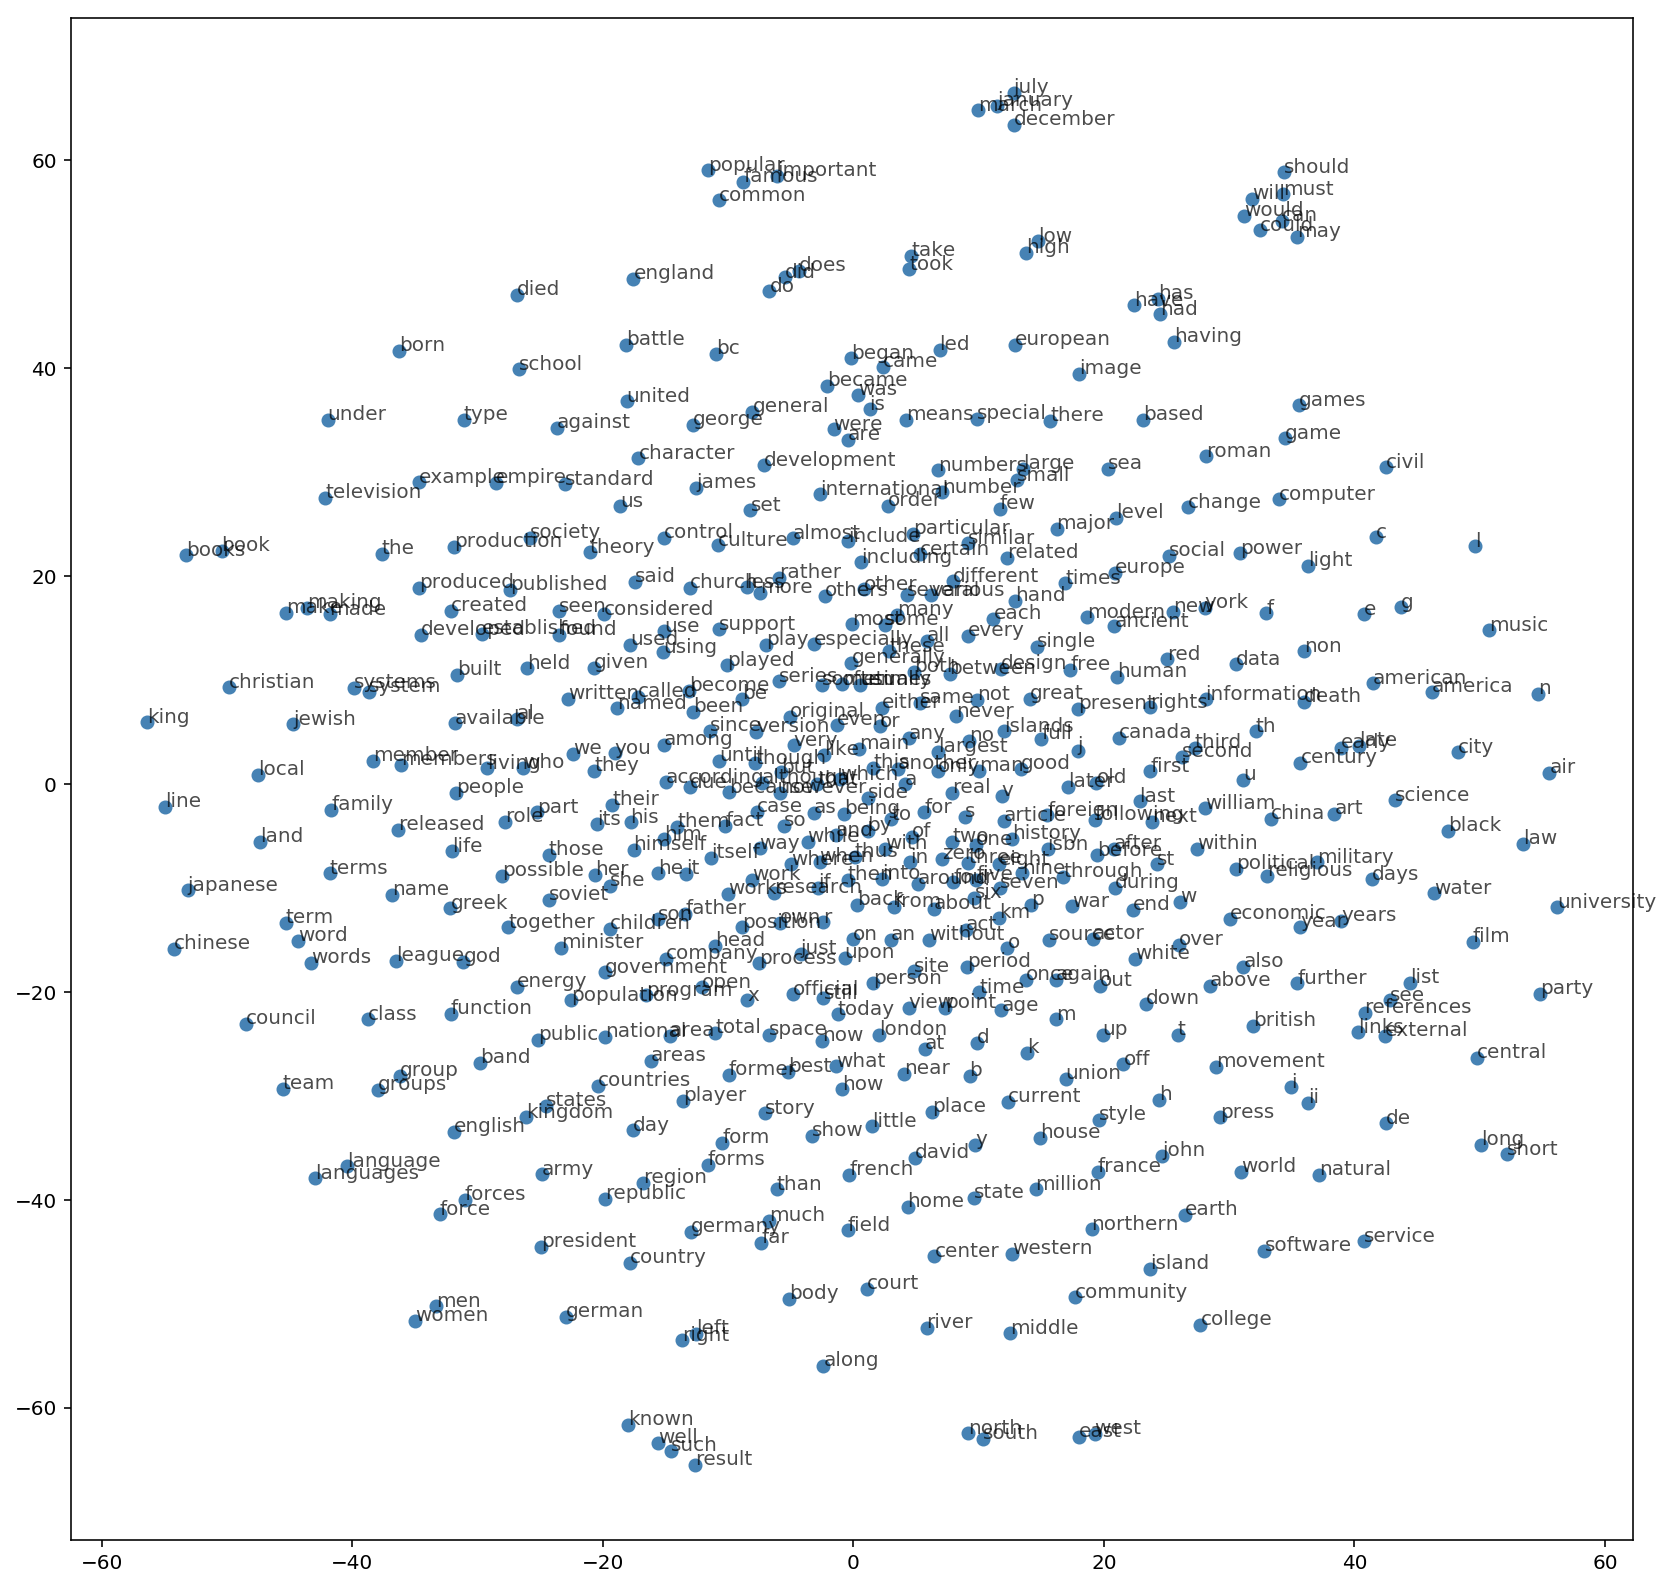

In [22]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)